# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

### EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?

### Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?


## Team
- Catalina Odizzio
- Margherita Philipp
- Agostina Alexandra Pissinis

# Import libraries & Data

In [233]:
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')


In [234]:
data_og = pd.read_csv('Data/data_BCN.csv')

# 1. Exploratory Data Analysis

In [235]:
data = data_og.copy()
TARGET = 'orders'
data

,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN
...,...,...,...
8761,2022-02-01 19:00:00,101.0,BCN
8762,2022-02-01 20:00:00,266.0,BCN
8763,2022-02-01 21:00:00,298.0,BCN
8764,2022-02-01 22:00:00,128.0,BCN


## Overview
The data is only for the city of Barcelona, Spain. It contains only information about the hour and the number of orders. There are no missing values.

Date range: 1st Feb 2021 to 1st Feb 2022, starting on a Monday and ending on a Tuesday. We turn the date column into a datetime object and set it as the index.

Neither 2021 nor 2022 is divisible by 4, so it s not a leap year and thus has 365 days. The data frame contain 366 days as the 1st Feb is inlcuded twice.

The data starts on a Monday and ends on a Tuesday. Recall that "we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week."

We notice that 18 hours are missing from the full sequence. However, they are all between midnight and 5am, so we simply impute them through a fill-foward algorithm. We also considered interpolation, but that would lead to numbers of orders that are not whole numbers.

In [236]:
# Get basic info about the data
print('data shape:', data.shape)
print(data.city.unique())
print('__________________________')
data.info()
print('__________________________')
print("missing values:\n" + str(data.isna().sum()))
print('__________________________')
data.head()

#print(data.head())
#print(data.tail())

data shape: (8766, 3)
['BCN']
__________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8766 non-null   object 
 1   orders  8766 non-null   float64
 2   city    8766 non-null   object 
dtypes: float64(1), object(2)
memory usage: 205.6+ KB
__________________________
missing values:
time      0
orders    0
city      0
dtype: int64
__________________________


,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


In [237]:
# Check data types
print(type(data.time[0]))
print(type(data.orders[0]))

# Convert time to datetime and set as index
print('__________________________')
data.time = pd.to_datetime(data.time)
data = data.set_index('time')
print('new index:', type(data.index))

# Inspect date rage
print('__________________________')
print('date range: ', data.index.min(), ' - ', data.index.max())
print('number of days: ', (data.index.max() - data.index.min()).days)

# Check for start and end date
print('__________________________')
print('first day:', data.index[0].weekday())  # start on a Monday (0)
print('last day:',data.index[-1].weekday()) # end on a Tuesday (1)


<class 'str'>
<class 'numpy.float64'>
__________________________
new index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
__________________________
date range:  2021-02-01 00:00:00  -  2022-02-01 23:00:00
number of days:  365
__________________________
first day: 0
last day: 1


In [238]:
original_length = len(data) #8766

print('Original frequency: ', data.index.freq)
print('Original hours: ', len(data))
print('__________________________')


for resolution in ['H','D', 'W', 'M']:
    data_temp = data.copy()

    data_temp = data_temp.resample(resolution) #Error I made: keep in mind that the interpolate() method does not modify the original DataFrame in-place but returns a new DataFrame with the interpolated values. Therefore, you need to assign the result of data_temp.resample('D').interpolate() back to data_temp to have the changes take effect.
    print('Frequency: ', data_temp.freq)

    resampled_length = len(data_temp)
    rows_added_or_dropped = resampled_length - original_length

    print(f'Post resample: number of {resolution}s in data: {resampled_length}')
    print(f"Rows added to data: {rows_added_or_dropped}")
    print('__________________________')

Original frequency:  None
Original hours:  8766
__________________________
Frequency:  <Hour>
Post resample: number of Hs in data: 8784
Rows added to data: 18
__________________________
Frequency:  <Day>
Post resample: number of Ds in data: 366
Rows added to data: -8400
__________________________
Frequency:  <Week: weekday=6>
Post resample: number of Ws in data: 53
Rows added to data: -8713
__________________________
Frequency:  <MonthEnd>
Post resample: number of Ms in data: 13
Rows added to data: -8753
__________________________


In [239]:
# Inpsect the rows with missing values after resampling and show that interpolation makes sense
data = data.resample('H').interpolate(method='nearest', kind='previoius') # don't use ffill - we want show the colums that were generated when resampling
missing_hours = data.loc[data.city.isna()]

# Fill NaN values in City column with BCN
data = data.fillna(method='ffill')

missing_hours

,orders,city
time,,
2021-02-15 00:00:00,0.0,NaN
2021-02-15 01:00:00,0.0,NaN
2021-02-15 02:00:00,0.0,NaN
2021-02-15 03:00:00,1.0,NaN
2021-02-15 04:00:00,1.0,NaN
2021-02-15 05:00:00,1.0,NaN
2021-06-07 00:00:00,0.0,NaN
2021-06-07 01:00:00,0.0,NaN
2021-06-07 02:00:00,0.0,NaN


In [240]:
# Show that the missing values are now filled (can be deleted)
missing_hours_2 = data.loc[missing_hours.index]
missing_hours_2

,orders,city
time,,
2021-02-15 00:00:00,0.0,BCN
2021-02-15 01:00:00,0.0,BCN
2021-02-15 02:00:00,0.0,BCN
2021-02-15 03:00:00,1.0,BCN
2021-02-15 04:00:00,1.0,BCN
2021-02-15 05:00:00,1.0,BCN
2021-06-07 00:00:00,0.0,BCN
2021-06-07 01:00:00,0.0,BCN
2021-06-07 02:00:00,0.0,BCN


## Timeseries plot
Data visulisations and simple statistics.

From a basic look at the data aggregated (resampled) at the daily, weekly, monthly and quarterly levels, we can see quite a lot of variation day-to-day, as well as an overall trend in growing order numbers. Only in August there is a clear dip, when Barcelona shuts down for the hottest month.

In [241]:
# Simple statistics:
print(data[[TARGET]].describe().round(2).T)

# This graph is static, i.e. you cannot zoom in
# data.plot(style='-',
#         linewidth=1.5,
#         figsize=(15, 5),
#         color=color_pal[1],
#         title='Hourly Glovo orders')
# plt.show()

# This graph is dynamic, i.e. you can zoom in and out
px.line(data, x=data.index, y=TARGET, title='Hourly Glovo orders')

         count  mean     std  min  25%   50%   75%    max
orders  8784.0  73.0  110.97  0.0  0.0  30.0  96.0  939.0


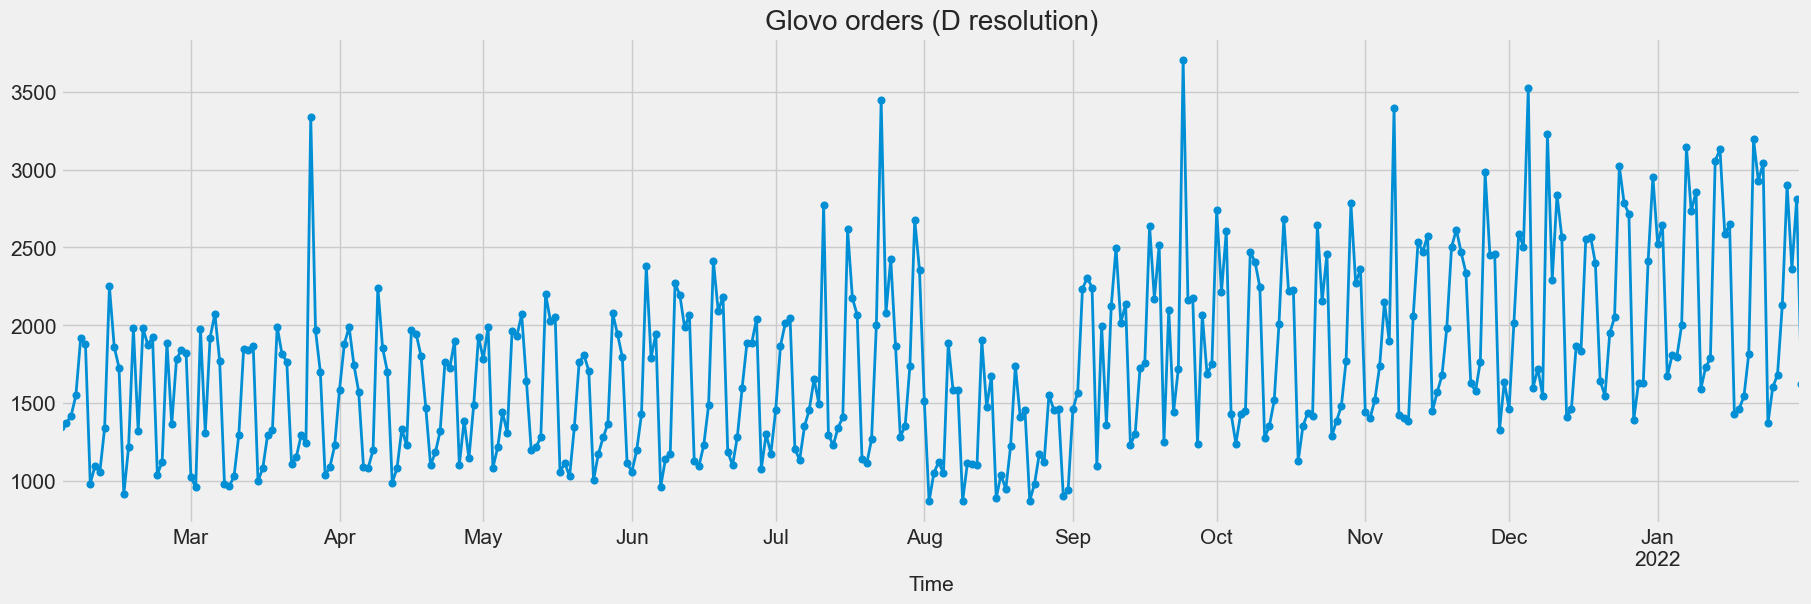

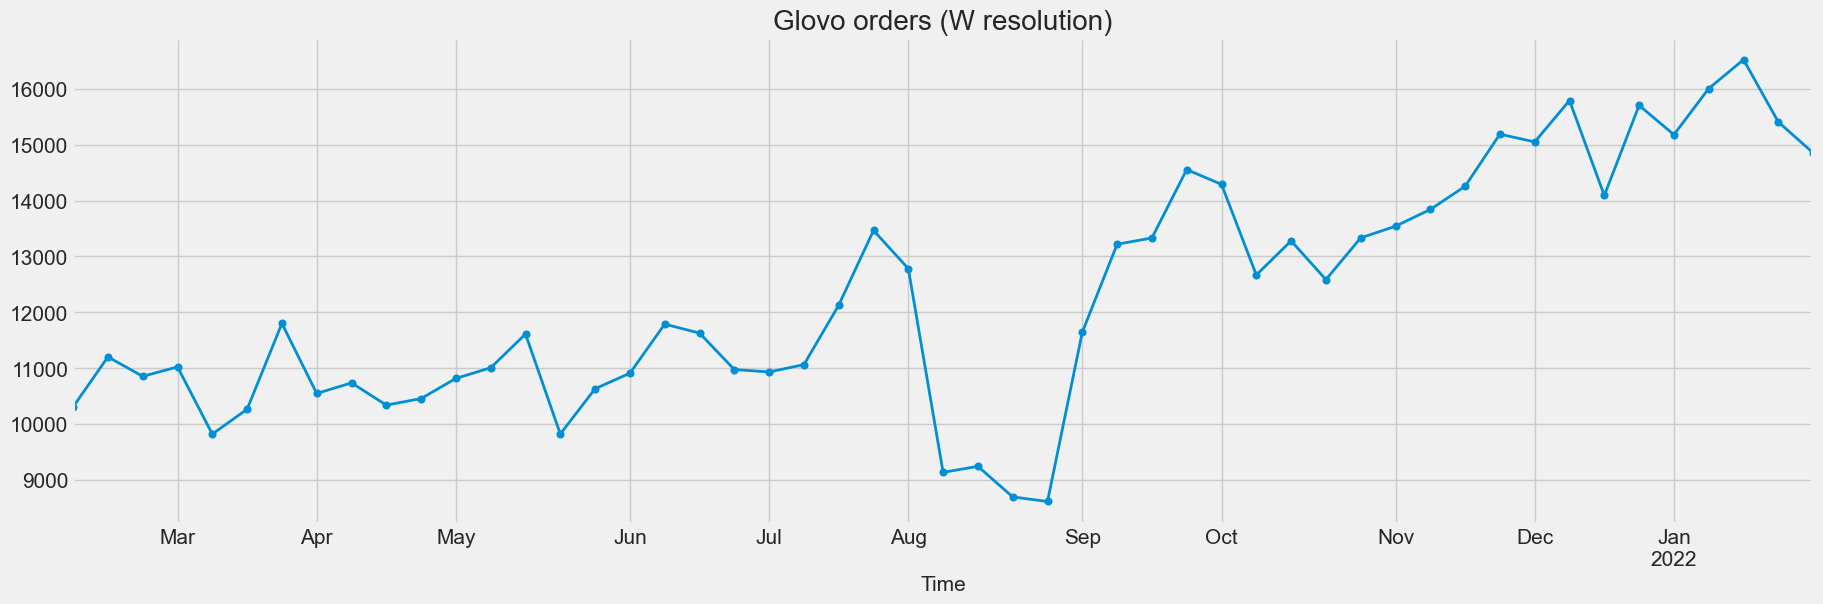

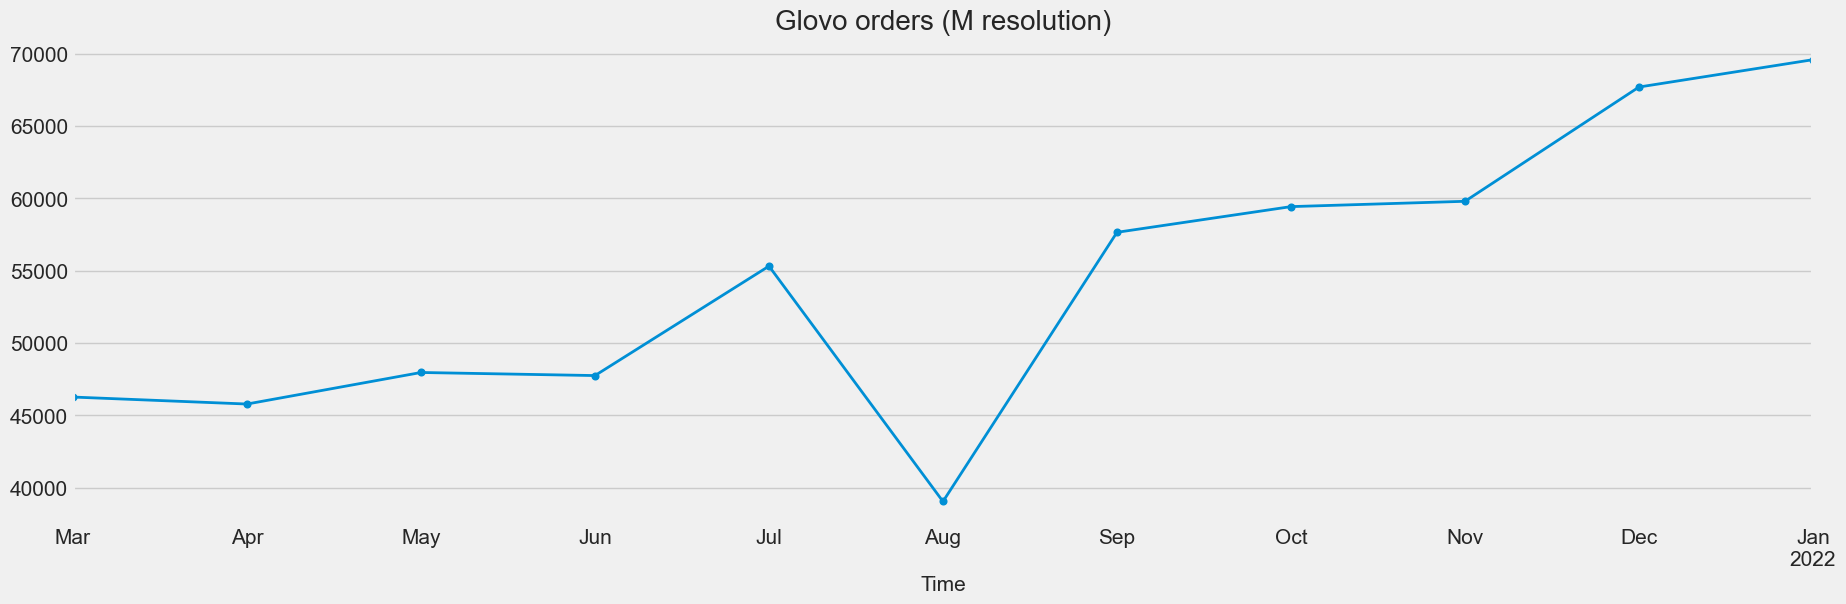

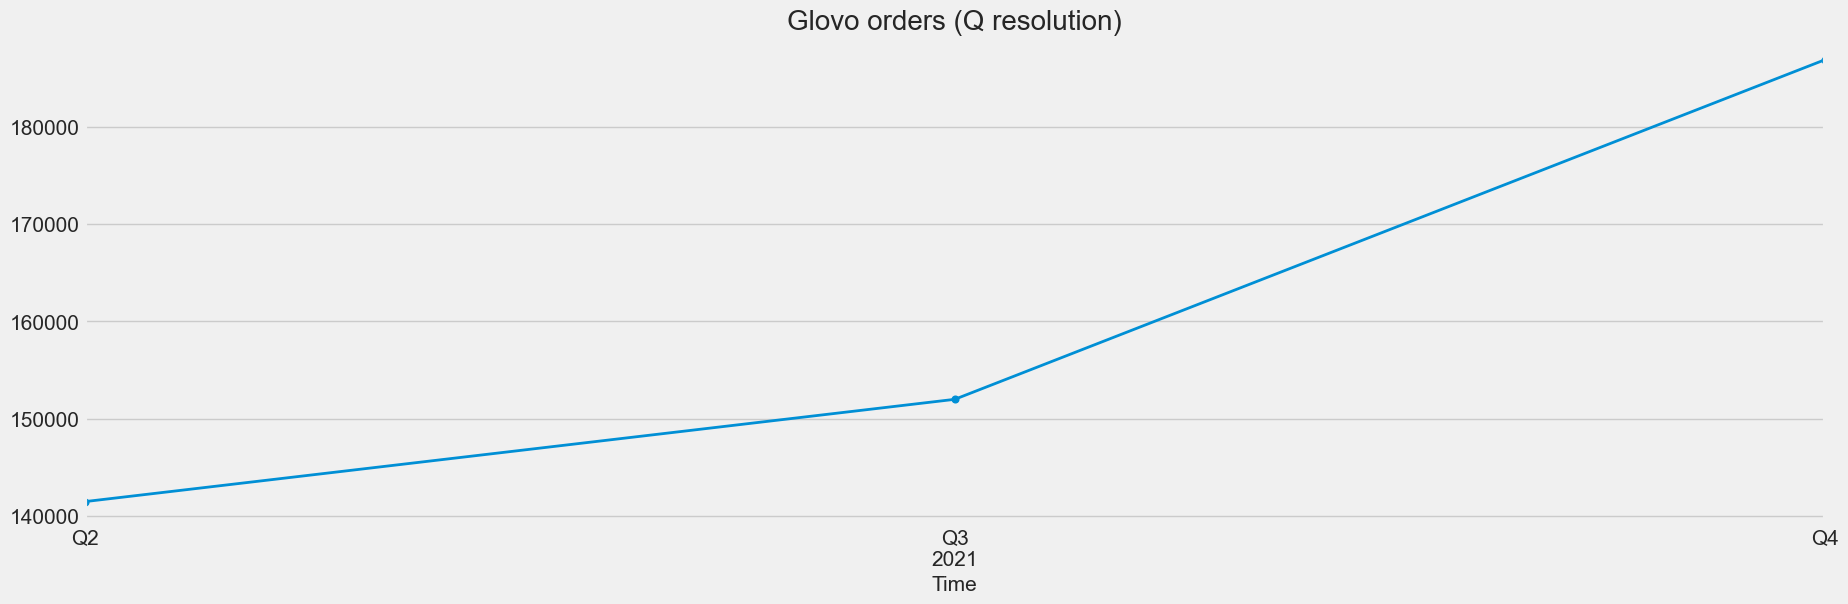

In [242]:
for resolution in ['D', 'W', 'M', 'Q']:
    fig, ax = plt.subplots(figsize=(20, 6))
    data[TARGET].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o', color=color_pal[0], fontsize=15, linewidth=2)
    ax.set_title(f'Glovo orders ({resolution} resolution)', fontsize=20)
    ax.set_xlabel('Time', fontsize=15)

## Inspecting trends and seasonality

**Breakdowns**
- Hours:
    - There are clearly the most order around Spanish dinner time, so 8-9pm.
    - Another spike occurs around lunchtime at 1-2pm.

- Weekdays:
    - There are more orders Friday to Sunday than the rest of the week.

- Months:
    - The largest interquratile ranges, highest medians, and densest tails of high outlighers can be observed for January and December.
    - August sees a dip in orders, presumably because many locals leave Barcelona, while tourists arrive and eat out rather than ordering in.

- Quarters:
    - The quarters containing the winter months (1: Jan, Feb, Mar; and 4: Oct, Nov, Dec) see more orders placed than the other two quarters.

In [243]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    #df['is_fr_wknd'] = np.where(df['dayofmonth'].isin([3, 4, 5, 6]), 1, 0)
    
    return df

data = create_features(data)
data['is_fr_wknd'] = np.where(data['dayofweek'].isin([4, 5, 6]), 1, 0)

#print(data.loc[data.index == '2021-09-24 21:00:00'])
data.head()

,orders,city,hour,dayofweek,quarter,month,year,dayofmonth,is_fr_wknd
time,,,,,,,,,
2021-02-01 00:00:00,0.0,BCN,0,0,1,2,2021,1,0
2021-02-01 01:00:00,0.0,BCN,1,0,1,2,2021,1,0
2021-02-01 02:00:00,0.0,BCN,2,0,1,2,2021,1,0
2021-02-01 03:00:00,0.0,BCN,3,0,1,2,2021,1,0
2021-02-01 04:00:00,0.0,BCN,4,0,1,2,2021,1,0


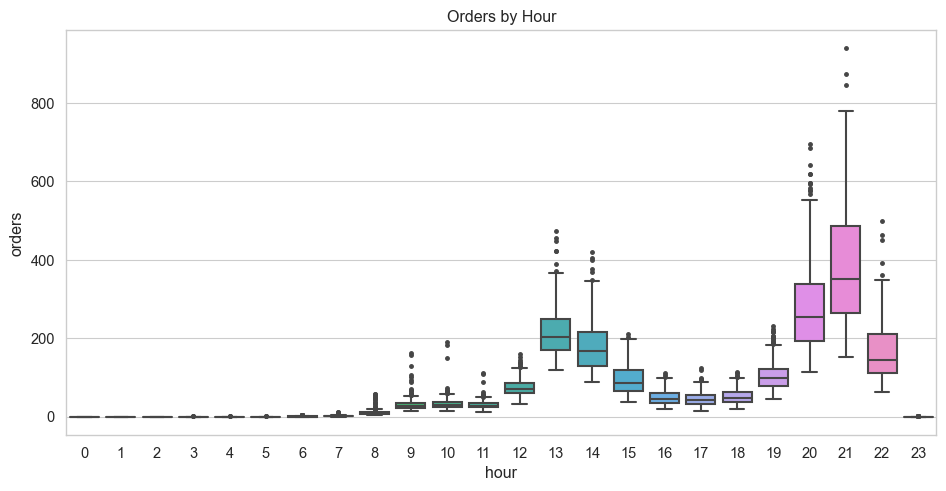

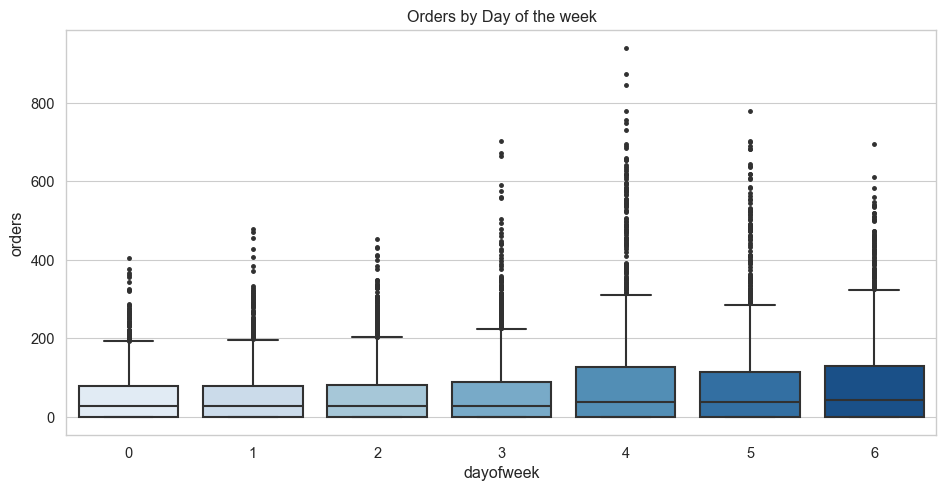

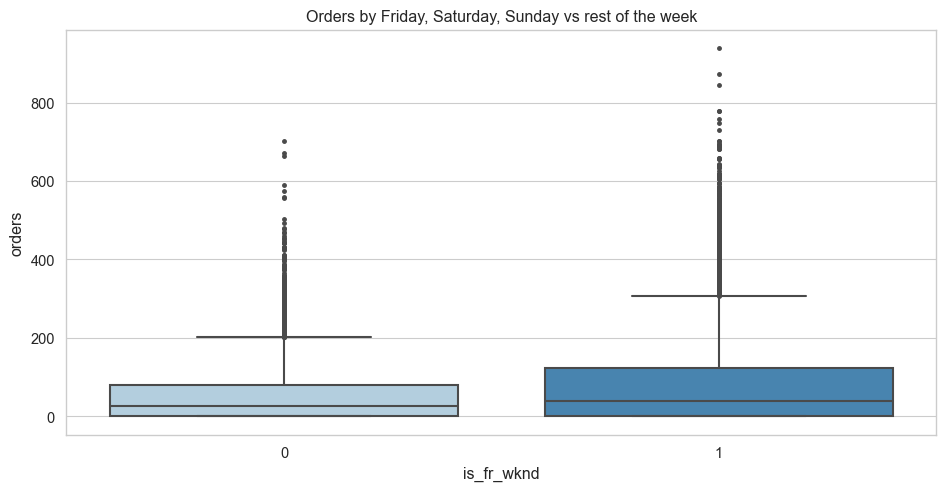

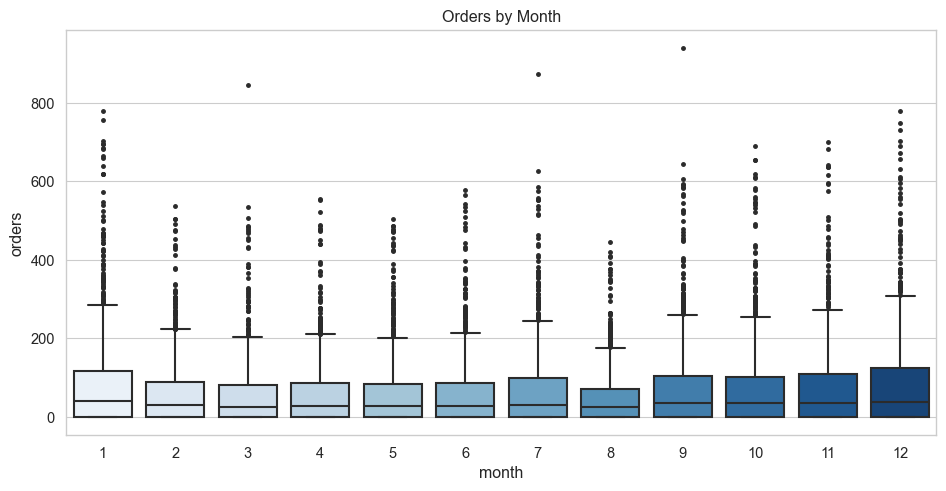

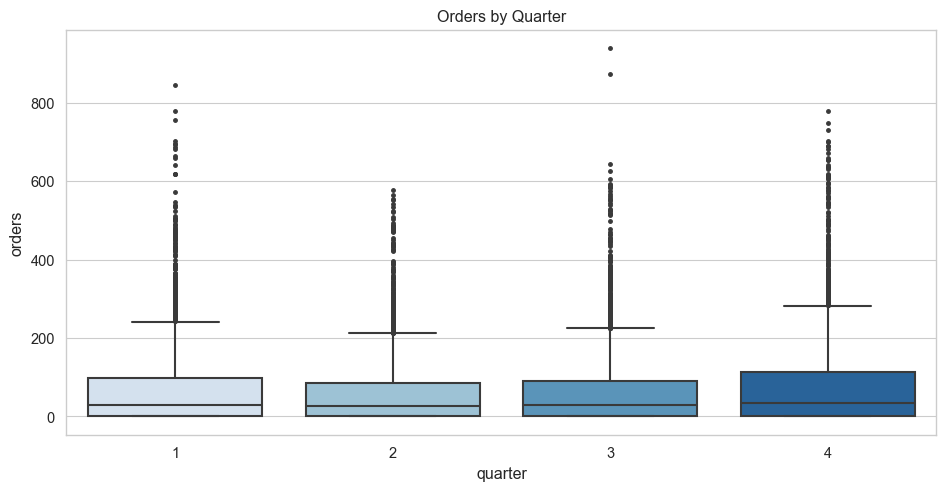

In [244]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.2)  

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=data, x='hour', y=TARGET, linewidth = 1.5, flierprops={"marker": "."})
ax.set_title('Orders by Hour')
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=data, x='dayofweek', y=TARGET, palette='Blues', linewidth = 1.5, flierprops={"marker": "."})
ax.set_title('Orders by Day of the week')
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=data, x='is_fr_wknd', y=TARGET, palette='Blues', linewidth = 1.5, flierprops={"marker": "."})
ax.set_title('Orders by Friday, Saturday, Sunday vs rest of the week') 
plt.show()


fig, ax = plt.subplots(figsize=(10,5))
box_plot = sns.boxplot(data=data, x='month', y=TARGET, palette='Blues', linewidth = 1.5, flierprops={"marker": "."})
ax.set_title('Orders by Month')
plt.show()

#medians = glovo.groupby(['month'])['orders'].median()
#vertical_offset = glovo['orders'].median() * 0.4 # offset from median for display

#for xtick in box_plot.get_xticks():
#    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#            horizontalalignment='center',size='small',color='red',weight='semibold')

fig, ax = plt.subplots(figsize=(10,5))
box_plot = sns.boxplot(data=data, x='quarter', y=TARGET, palette='Blues', linewidth = 1.5, flierprops={"marker": "."})
ax.set_title('Orders by Quarter')
plt.show()

## Inspecting outliers
**Outliers**

Only very few days see more than 700 orders, and even fewer see 800 orders. We look at the days with the highest orders and research what may have caused the spikes, commenting on whether these could be foreseen or not. 

Below we inspect the periods with the highest outliers: We note that almost all are Fridays (day 4) or Saturdays (day 5), and all of them occur in the time slot 9pm to 10pm (i.e. Spanish dinner time) which was already seen in the visualisations above.

- 2021-09-24, Friday, El viernes 24 de septiembre del 2021, día de la Mercè (o de la Virgen de la Merced), es fiesta local en varios municipios de España, muchos de ellos de Catalunya. ([Source](https://www.elperiodico.com/es/barcelona/20210919/merce-septiembre-2021-festivo-12093514)) This is an annual festival that can be planned for in advance.


- 2021-07-23, Friday, El mayor Urban Beach Festival de Europa celebra su 5ª edición en Barcelona con toda la energía y ganas de petarlo. ([Source](https://reggaetonbeachfestival.com/es/festivales/summer/barcelona)) Festivals like this one are also announced well in advance, so can be taken into account. However, we are not sure whether this festival is truly the cause for the spike as we would have expected that other festivals like Primavera Sound (Jun 2, 2021 – Jun 6, 2021) to also appear in the outliers. One reason could be a difference in who goes: if Primavera is mostly attended by people who don't live in Barcelona, perhaps they are more likely to go to restaurants. While locals going to a festival may order home before heading out.

- 2021-03-26, Friday - home game for Barcelona basketball club. This took place in the middle of the day, but no one was watching in person, presumably due to Covid restrictions. Barcelona won and people may have celebrated. ([Source](https://www.youtube.com/watch?v=jq2wCVNXknc)) Such events are slightly harder to forsee, as they require knowledge of when relevant teams play in sporting events, which may depend on how a championship has gone in recent weeks or even days.

- 2021-12-25, Saturday, Christmas Day. ([Source](https://ajuntament.barcelona.cat/calendarifestius/en/)) This is an easily predicted annual event.

- 2022-01-07, Friday, Epiphany. (Source as above) This is an easily predicted annual event.

In [245]:
data.loc[data[TARGET] > 700].sort_values(by=TARGET, ascending=False)

,orders,city,hour,dayofweek,quarter,month,year,dayofmonth,is_fr_wknd
time,,,,,,,,,
2021-09-24 21:00:00,939.0,BCN,21,4,3,9,2021,24,1
2021-07-23 21:00:00,873.0,BCN,21,4,3,7,2021,23,1
2021-03-26 21:00:00,846.0,BCN,21,4,1,3,2021,26,1
2021-12-25 21:00:00,778.0,BCN,21,5,4,12,2021,25,1
2022-01-07 21:00:00,778.0,BCN,21,4,1,1,2022,7,1
2022-01-14 21:00:00,757.0,BCN,21,4,1,1,2022,14,1
2021-12-24 21:00:00,748.0,BCN,21,4,4,12,2021,24,1
2021-12-31 21:00:00,731.0,BCN,21,4,4,12,2021,31,1
2021-12-09 21:00:00,703.0,BCN,21,3,4,12,2021,9,0


## Checking for stationarity
We use the Augmented Dickey-Fuller (ADF) test to check for stationarity and find that the data is stationary.

In [246]:
# Check that working with resampled version of the data
print(type(data.index))
print(data.index.freq)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<Hour>


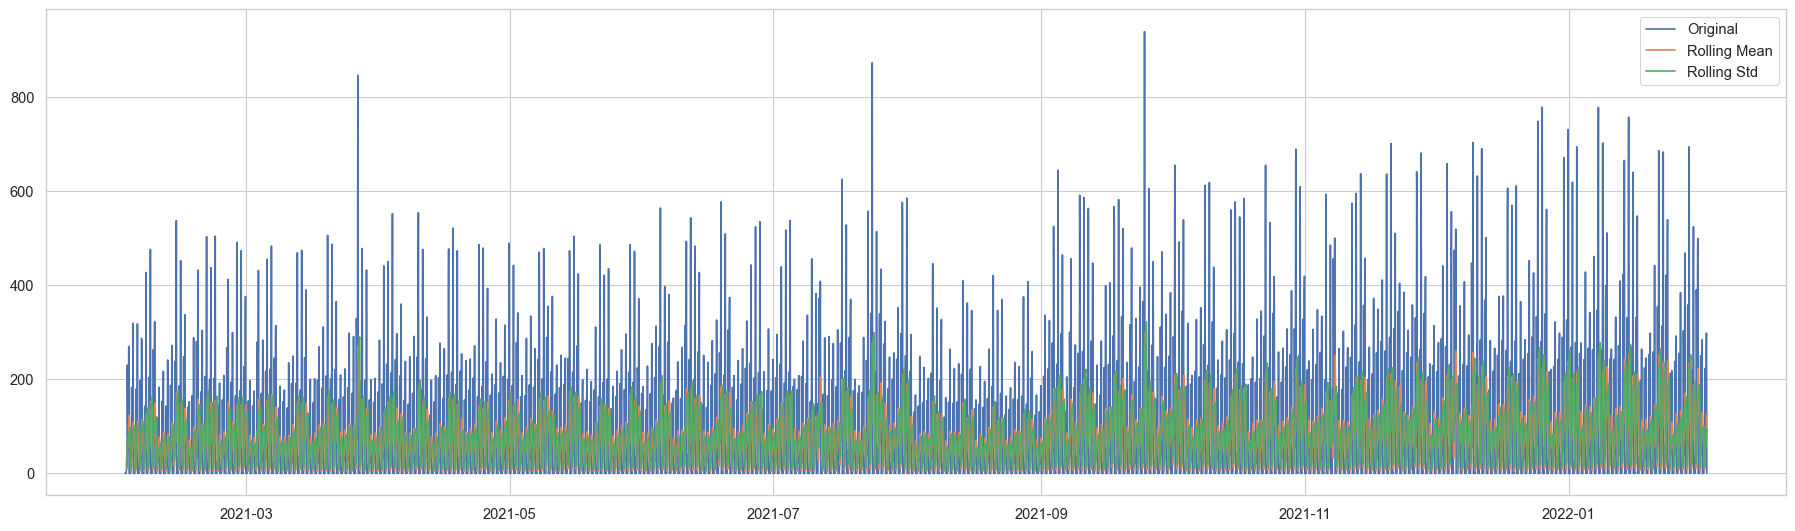

ADF Statistic: -10.602128764916943
p-value: 6.13e-19
Critical Values:
	1%: -3.43109790993778
	5%: -2.861870526484161
	10%: -2.566945934275714


In [247]:
# Augmented Dickey-Fuller (ADF) test to check for stationarity

from statsmodels.tsa.stattools import adfuller

rolling_mean = data[TARGET].rolling(window=12).mean()
rolling_std = data[TARGET].rolling(window=12).std()

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(data[TARGET], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.show()

result = adfuller(data[TARGET])

print('ADF Statistic:', result[0])
print('p-value:', round(result[1], 21))
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

Interpreting the ADF test results:
- The ADF statistic should be more negative (i.e., smaller in magnitude) than the critical values for the data to be stationary: in our data, this is the case - the statistic is a lot more negative than the critical values.

- The p-value should be less than a significance level (e.g., 0.05) for the data to be stationary: in our data, this is the case - the p-value is 6.13e-19.
- Therefore we conclude that our data is indeed stationary, which is desirable property for many time series analysis techniques, as it simplifies modeling and forecasting

## Decomposition: seasonal adjustment and detrending

We visualise the data for an additive decomposition and generate an alternative dataframe that could be used for predictions.

When seasonally adjusting and detrending data, we get NaN values at the start and end of our data. Therefore, if we want to work with that dataframe rather than the original one, we need to accept that we will work with slightly less data.

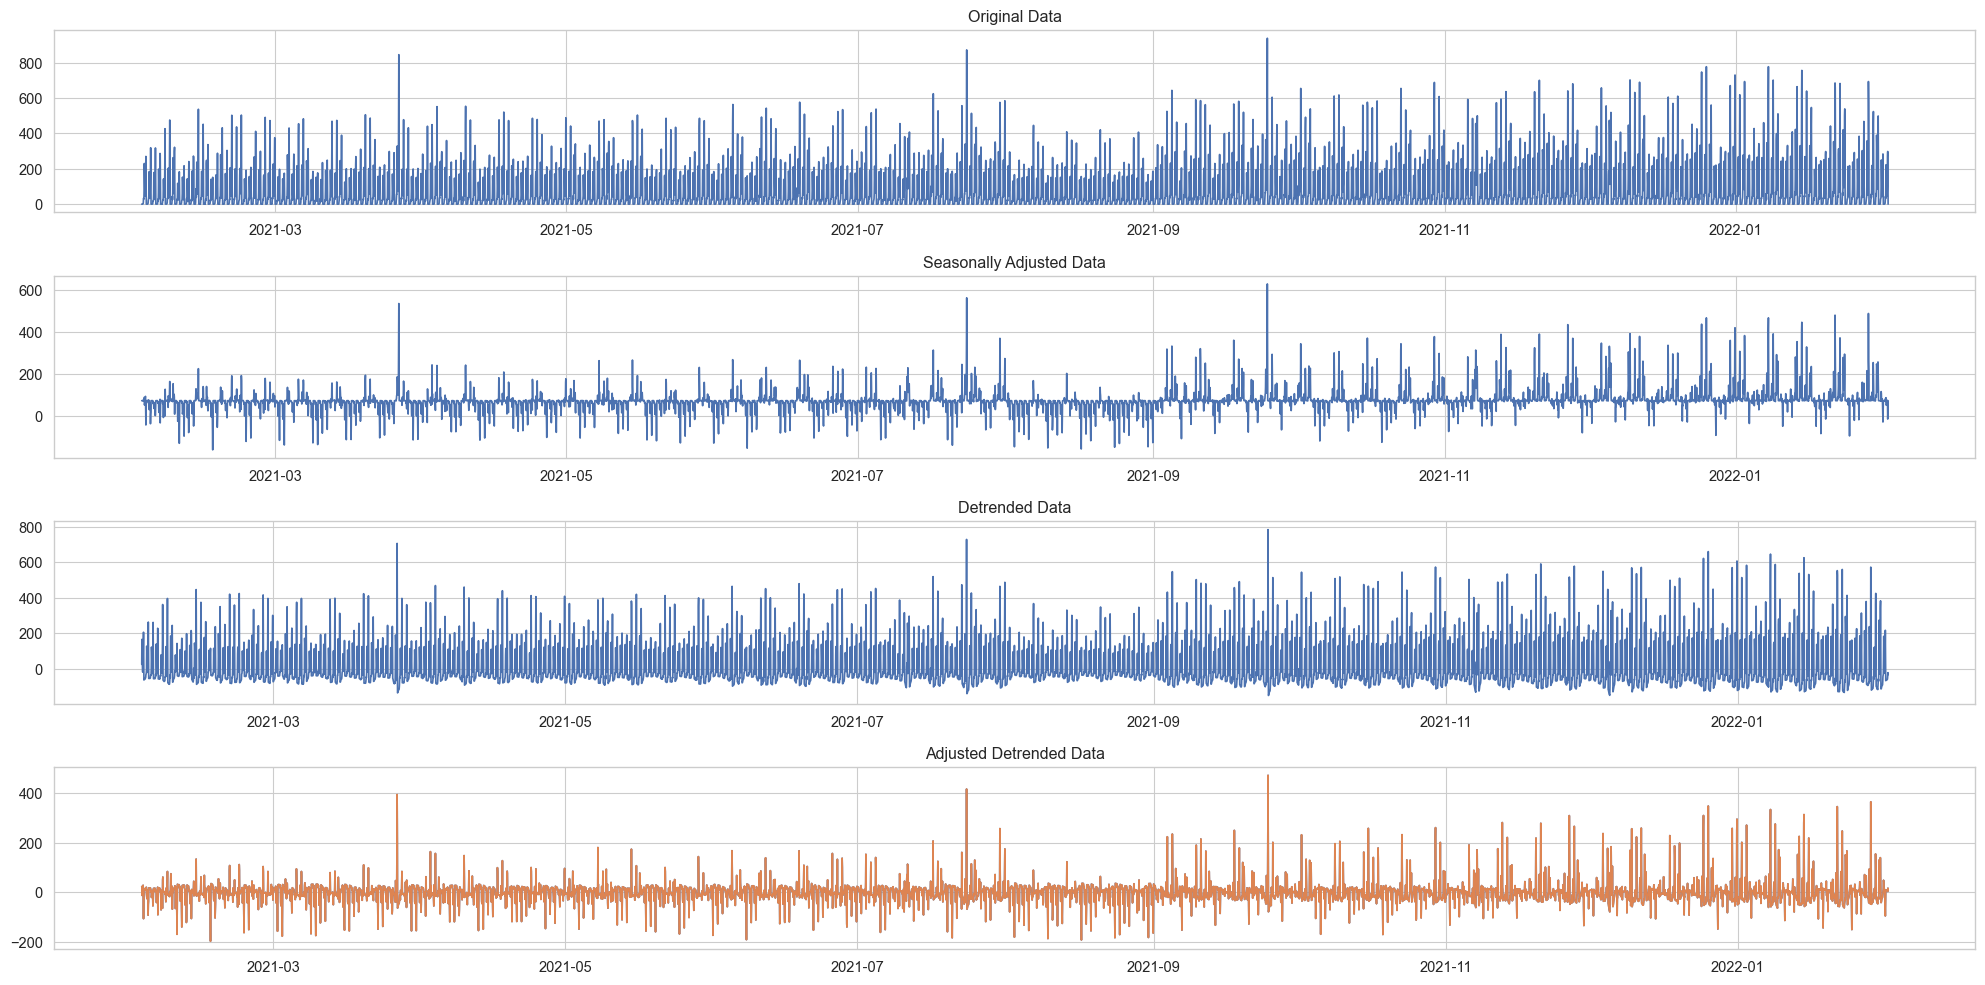

In [248]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(data[TARGET], model='additive') # NB: Multiplicative seasonality is not appropriate for zero and negative values

# Get the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Calculate the seasonally adjusted data
seasonally_adjusted = data[TARGET] - seasonal
detrended = data[TARGET] - trend
adjusted_detrended = data[TARGET] - trend - seasonal

# Plotting the original and seasonally adjusted data
plt.figure(figsize=(20, 10))
plt.subplot(4, 1, 1)
plt.plot(data[TARGET])
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(seasonally_adjusted)
plt.title('Seasonally Adjusted Data')

plt.subplot(4, 1, 3)
plt.plot(detrended)
plt.title('Detrended Data')

plt.subplot(4, 1, 4)
plt.plot(adjusted_detrended)
plt.plot(residual) # Residuals are the same as adjusted detrended data, so overlay them
plt.title('Adjusted Detrended Data')

plt.tight_layout()
plt.show()

In [249]:
# turn the adjusted detrended data into a dataframe
data_adj = residual.to_frame()

# check if missing values are as expected: it drops the first 12 hours and the last 12 hours of the frame
missing_hours = data_adj.isna().sum()
print('Number of missing rows/hours (should be just within first and last days in the dataset): ', missing_hours)

# drop missing values, rename the column and add the features from above back in
data_adj.dropna(inplace=True)
data_adj.columns = ['orders_adj']
data_adj = create_features(data_adj)

# check that the index is still datetime and frequency is still hourly
print(data_adj.index.freq)
data_adj

Number of missing rows/hours (should be just within first and last days in the dataset):  resid    24
dtype: int64
<Hour>


,orders_adj,hour,dayofweek,quarter,month,year,dayofmonth
time,,,,,,,
2021-02-01 12:00:00,23.104532,12,0,1,2,2021,1
2021-02-01 13:00:00,22.053574,13,0,1,2,2021,1
2021-02-01 14:00:00,-12.794920,14,0,1,2,2021,1
2021-02-01 15:00:00,-3.004783,15,0,1,2,2021,1
2021-02-01 16:00:00,14.320423,16,0,1,2,2021,1
...,...,...,...,...,...,...,...
2022-02-01 07:00:00,9.874578,7,1,1,2,2022,1
2022-02-01 08:00:00,7.631987,8,1,1,2,2022,1
2022-02-01 09:00:00,3.126884,9,1,1,2,2022,1


In [250]:
# We ensure the dataframe starts on a Monday again by dropping the next week
data_adj = data_adj.loc[data_adj.index >= pd.to_datetime('2021-02-08')]

# We also drop an extra day at the end, so we predict up until a Sunday night
data_adj = data_adj.loc[data_adj.index < pd.to_datetime('2022-01-31')]
data_adj


,orders_adj,hour,dayofweek,quarter,month,year,dayofmonth
time,,,,,,,
2021-02-08 00:00:00,-3.526689,0,0,1,2,2021,8
2021-02-08 01:00:00,-0.214646,1,0,1,2,2021,8
2021-02-08 02:00:00,6.409898,2,0,1,2,2021,8
2021-02-08 03:00:00,11.380674,3,0,1,2,2021,8
2021-02-08 04:00:00,13.505103,4,0,1,2,2021,8
...,...,...,...,...,...,...,...
2022-01-30 19:00:00,50.376701,19,6,1,1,2022,30
2022-01-30 20:00:00,139.922363,20,6,1,1,2022,30
2022-01-30 21:00:00,70.754772,21,6,1,1,2022,30


# 2. Modelling

We present models fit to both the original and the de-trended data. We first adjust the original data to also end on a Sunday.

In [251]:
# We also drop a one day at the end, so we predict up until a Sunday night

data = data.loc[data.index < pd.to_datetime('2022-01-31')]
data

,orders,city,hour,dayofweek,quarter,month,year,dayofmonth,is_fr_wknd
time,,,,,,,,,
2021-02-01 00:00:00,0.0,BCN,0,0,1,2,2021,1,0
2021-02-01 01:00:00,0.0,BCN,1,0,1,2,2021,1,0
2021-02-01 02:00:00,0.0,BCN,2,0,1,2,2021,1,0
2021-02-01 03:00:00,0.0,BCN,3,0,1,2,2021,1,0
2021-02-01 04:00:00,0.0,BCN,4,0,1,2,2021,1,0
...,...,...,...,...,...,...,...,...,...
2022-01-30 19:00:00,199.0,BCN,19,6,1,1,2022,30,1
2022-01-30 20:00:00,464.0,BCN,20,6,1,1,2022,30,1
2022-01-30 21:00:00,499.0,BCN,21,6,1,1,2022,30,1


In [252]:
# Generate test-train split

mondays = np.unique(data.index[data.index.dayofweek == 0].date)

print('number of mondays', len(mondays))
print(mondays[-5:])

number of mondays 52
[datetime.date(2021, 12, 27) datetime.date(2022, 1, 3)
 datetime.date(2022, 1, 10) datetime.date(2022, 1, 17)
 datetime.date(2022, 1, 24)]


first day in test: 0 (0 means Monday)


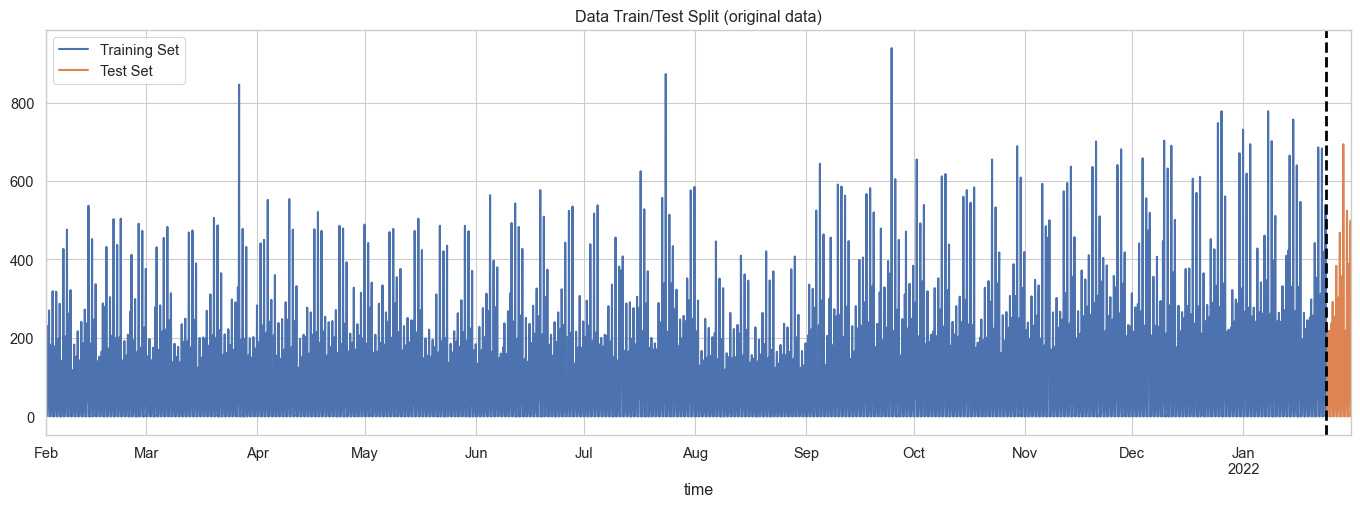

first day in test: 0 (0 means Monday)


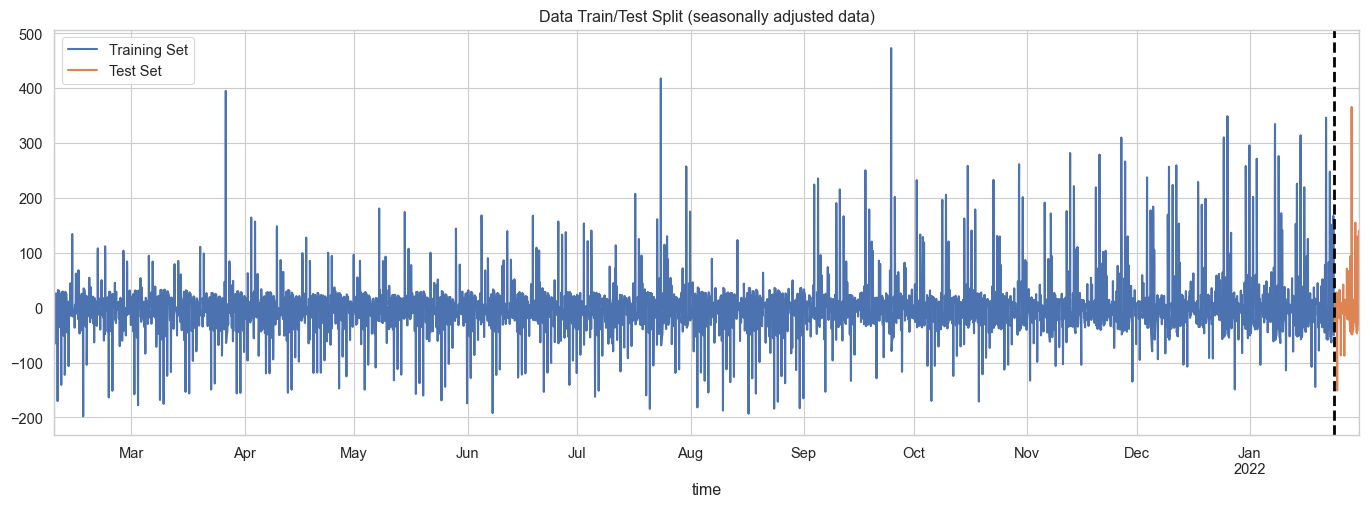

In [253]:
# Determine cut-off date: choose one of the Mondays above

cut_off_date = str(datetime.date(2022, 1, 24))#choose last Monday

#### For original data

TARGET = 'orders'

# Test train split
train = data.loc[data.index < cut_off_date]
test = data.loc[data.index >= cut_off_date]

#cut_off_date: Monday
print('first day in test:', test.index[0].weekday(), '(0 means Monday)')

fig, ax = plt.subplots(figsize=(15, 5))
train[TARGET].plot(ax=ax, label='Training Set', title='Data Train/Test Split (original data)', linewidth = 1.5)
test[TARGET].plot(ax=ax, label='Test Set', linewidth = 1.5)
ax.axvline(cut_off_date, color='black', ls='--', linewidth = 2)
ax.legend(['Training Set', 'Test Set'])
plt.show()

#### For adjusted data

TARGET_2 = 'orders_adj'

# Test train split
train_adj = data_adj.loc[data_adj.index <= cut_off_date]
test_adj = data_adj.loc[data_adj.index > cut_off_date]

#cut_off_date: Monday
print('first day in test:', test_adj.index[0].weekday(), '(0 means Monday)')

fig, ax = plt.subplots(figsize=(15, 5))
train_adj[TARGET_2].plot(ax=ax, label='Training Set', title='Data Train/Test Split (seasonally adjusted data)', linewidth = 1.5)
test_adj[TARGET_2].plot(ax=ax, label='Test Set', linewidth = 1.5)
ax.axvline(cut_off_date, color='black', ls='--', linewidth = 2)
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [292]:
# Plot for predictions

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, days_before=14):
    
    time_to_viz = pd.Timestamp(test_df.index.min()) - pd.Timedelta(days=days_before)
    real = pd.concat([train_df, test_df]).loc[time_to_viz:, TARGET]
    fitted = fitted.loc[time_to_viz:] if fitted is not None else None
    
    fig, ax = plt.subplots(figsize=(20, 6))
    
    ax.plot(real, label='real values')
    if fitted is not None:
        ax.plot(fitted, label='fitted values')

    ax.plot(short_forecast, label='forecasted values (short)')
    if long_forecast is not None:
        ax.plot(long_forecast, label='forecasted values (long)')
    
    ax.set_title(name)
    ax.legend()

    return round(mean_squared_error(test_df[TARGET], short_forecast), 2), round(smape(test_df[TARGET], short_forecast), 2)

## 2.1. Rolling mean models

As a starting point, we use a rolling mean model. To prevent data leakage, we refrain from using the test data for prediction. Instead, we group the data by hour and shift it by 7 positions, as we aim to forecast one week. Then, we compute the mean within the defined window size.

In [293]:
# Train and test sets

_train = train.copy()
_test = test.copy()

In [294]:
# Save models' metrics

losses = {}

rolling_mean    (8003.88, 51.03)
dtype: object


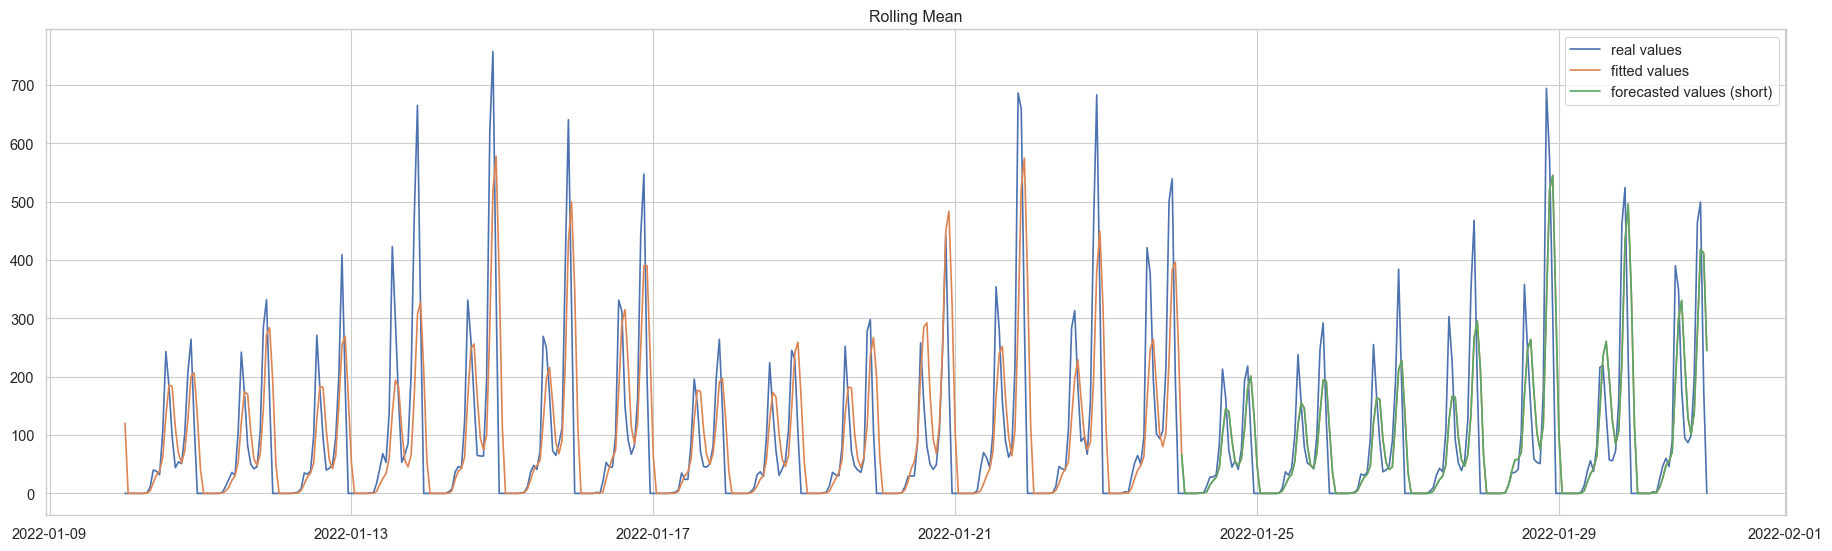

In [295]:
# Rolling mean

fitted_values = pd.concat([_train, _test.assign(orders=np.nan)]).sort_index()

fitted_values = (
    fitted_values.reset_index().set_index(['time', 'hour'])
    .groupby("hour").shift(7)["orders"].reset_index(level=1)
    .rolling(window=3, min_periods=1)["orders"]
    .mean()
    .sort_index()
)

losses['rolling_mean'] = plot_predictions(_train, _test, fitted_values.iloc[-len(_test):], None, fitted_values, 'Rolling Mean')

print(pd.Series(losses).sort_values())

## 2.2. ARIMA models
Here we use no exogenous variables or extra features such as what day of the week it is.



rolling_mean      (8003.88, 51.03)
arima_1_0_0     (16991.23, 120.49)
dtype: object


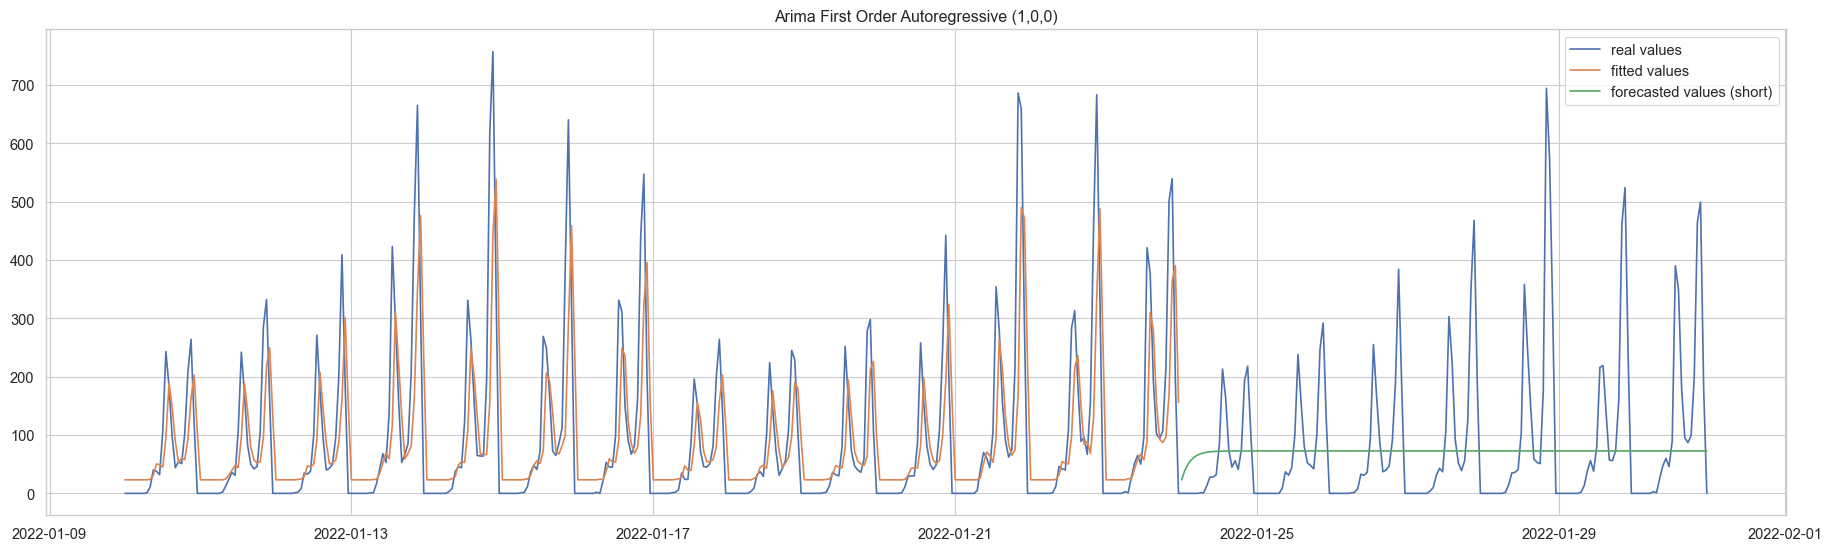

In [296]:
# First Order Autoregressive

from sktime.forecasting.arima import ARIMA

arima_fo_AR = ARIMA(order=(1, 0, 0))

train_arima_rs = train.copy()
test_arima_rs = test.copy()

_train = train_arima_rs[TARGET].copy()
arima_fo_AR = arima_fo_AR.fit(_train)

losses['arima_1_0_0'] = plot_predictions(train_df= train_arima_rs, test_df=test_arima_rs,
                                         short_forecast= arima_fo_AR.predict(test_arima_rs.index), long_forecast=None,
                                         fitted= arima_fo_AR.predict(train_arima_rs.index),
                                         name= 'Arima First Order Autoregressive (1,0,0)', days_before= diplay_days_before)

print(pd.Series(losses).sort_values())

rolling_mean      (8003.88, 51.03)
arima_1_0_0     (16991.23, 120.49)
arima_0_1_0       (24665.7, 200.0)
dtype: object


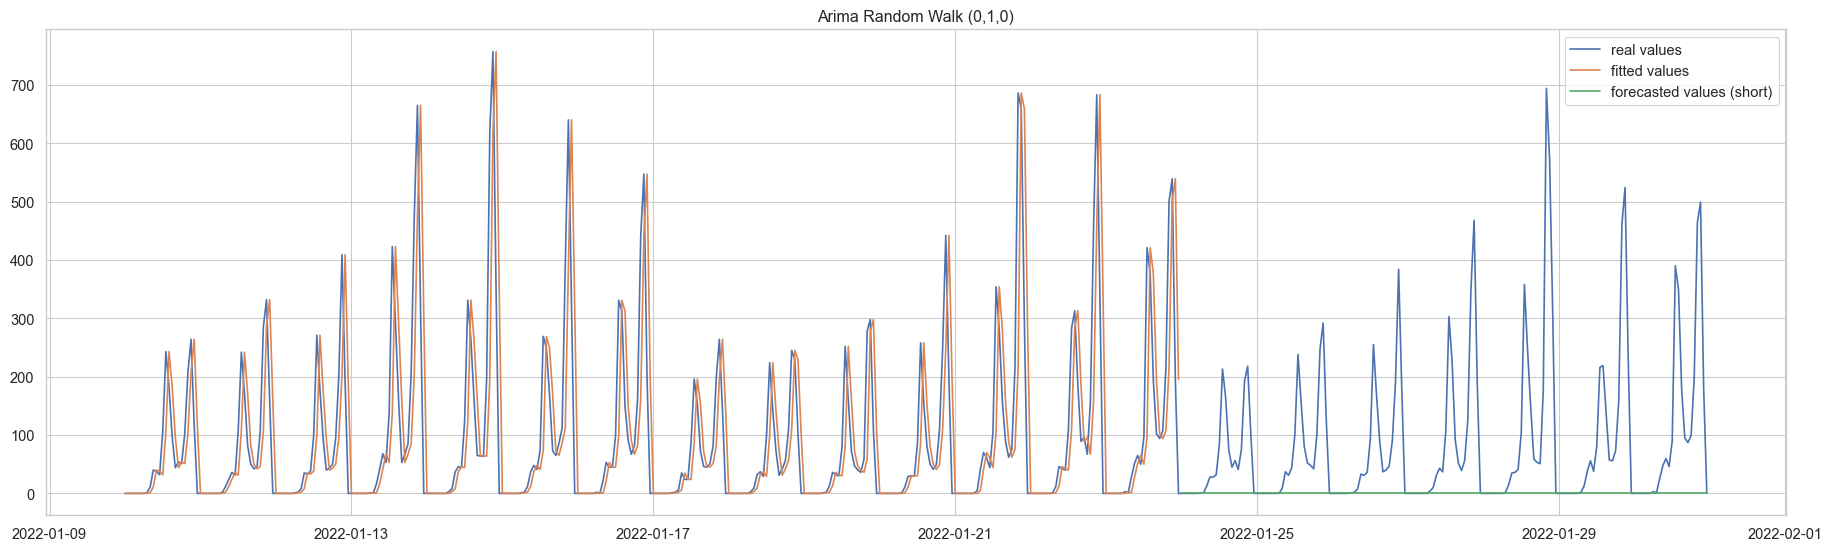

In [297]:
# Random Walk
arima_RW = ARIMA(order=(0, 1, 0))

_train = train_arima_rs[TARGET].copy()
arima_RW = arima_RW.fit(_train)

losses['arima_0_1_0'] = plot_predictions(train_arima_rs, test_arima_rs,
                                         arima_RW.predict(test_arima_rs.index), None,
                                         arima_RW.predict(train_arima_rs.index), name= 'Arima Random Walk (0,1,0)', days_before= diplay_days_before)
print(pd.Series(losses).sort_values())

rolling_mean      (8003.88, 51.03)
arima_1_0_0     (16991.23, 120.49)
arima_0_1_0       (24665.7, 200.0)
arima_1_1_0      (43782.28, 200.0)
dtype: object


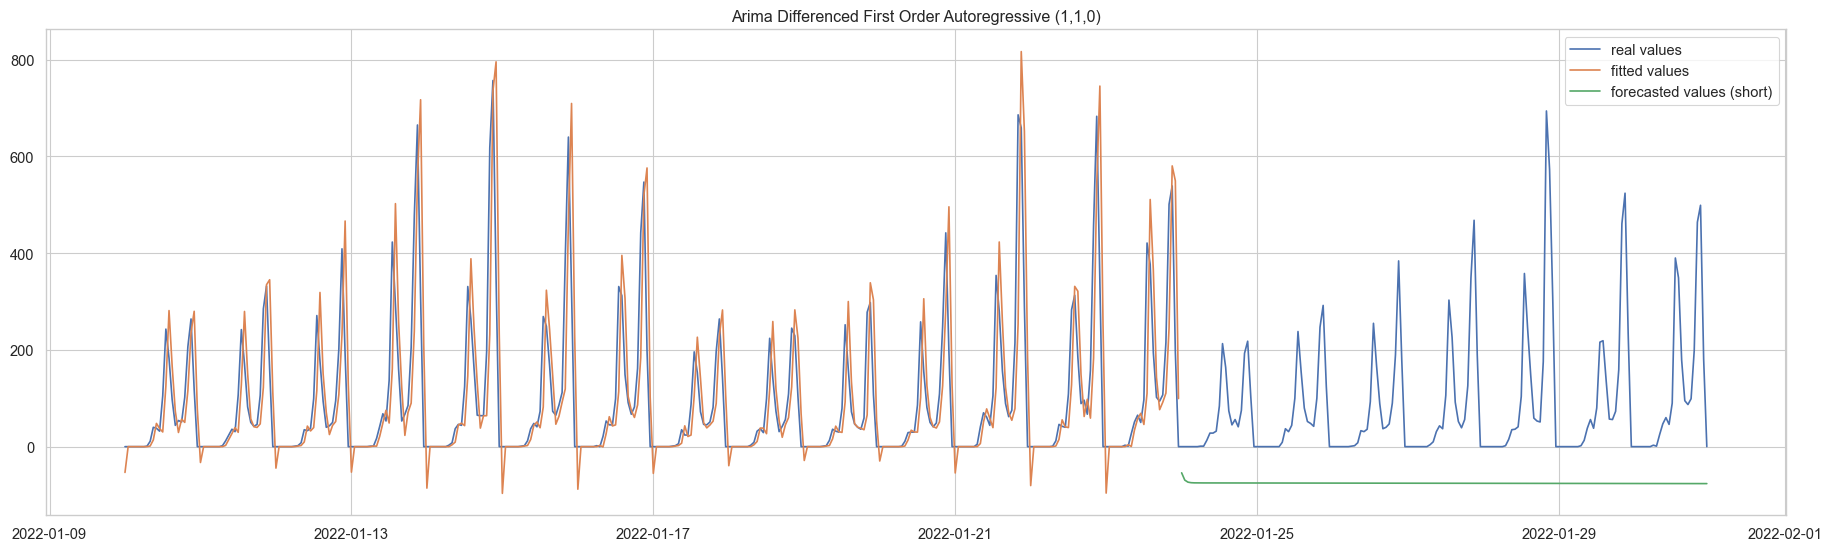

In [298]:
# Differenced first-order autoregressive model
arima_df_DFF = ARIMA(order=(1, 1, 0))

_train = train_arima_rs[TARGET].copy()
arima_df_DFF = arima_df_DFF.fit(_train)
#print(arima_df_DFF.summary())

losses['arima_1_1_0'] = plot_predictions(train_arima_rs, test_arima_rs,
                                         arima_df_DFF.predict(test_arima_rs.index), None,
                                         arima_df_DFF.predict(train_arima_rs.index), name= 'Arima Differenced First Order Autoregressive (1,1,0)', 
                                         days_before= diplay_days_before)
print(pd.Series(losses).sort_values())

rolling_mean      (8003.88, 51.03)
arima_1_0_0     (16991.23, 120.49)
arima_0_1_0       (24665.7, 200.0)
arima_1_1_1      (25548.91, 200.0)
arima_1_1_0      (43782.28, 200.0)
dtype: object


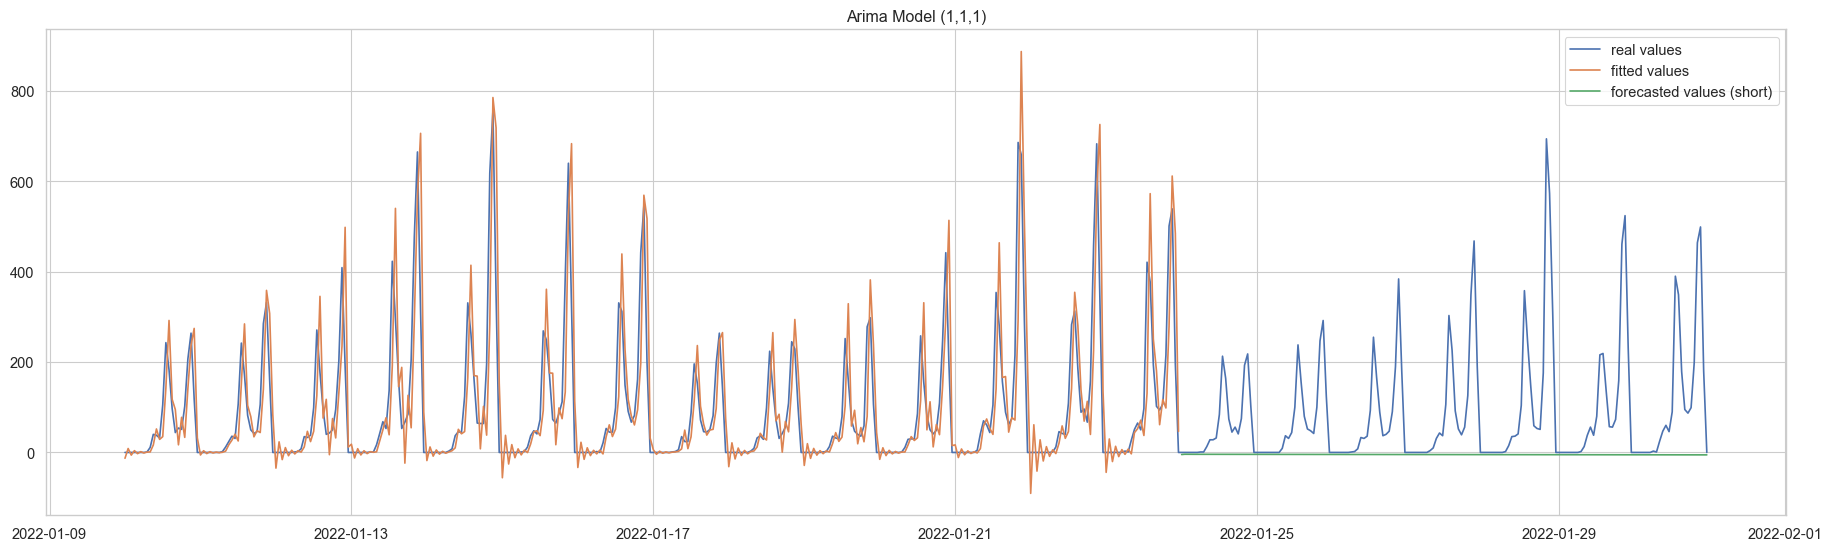

In [299]:
## Stadars model
arima_df_ST = ARIMA(order=(1, 1, 1))

_train = train_arima_rs[TARGET].copy()
arima_df_ST = arima_df_ST.fit(_train)

losses['arima_1_1_1'] = plot_predictions(train_arima_rs, test_arima_rs,
                                         arima_df_ST.predict(test_arima_rs.index), None,
                                         arima_df_ST.predict(train_arima_rs.index), name= 'Arima Model (1,1,1)', days_before= diplay_days_before)
print(pd.Series(losses).sort_values())

rolling_mean      (8003.88, 51.03)
arima_1_0_0     (16991.23, 120.49)
arima_0_1_0       (24665.7, 200.0)
arima_1_1_1      (25548.91, 200.0)
arima_0_2_2       (28711.6, 200.0)
arima_1_1_0      (43782.28, 200.0)
dtype: object


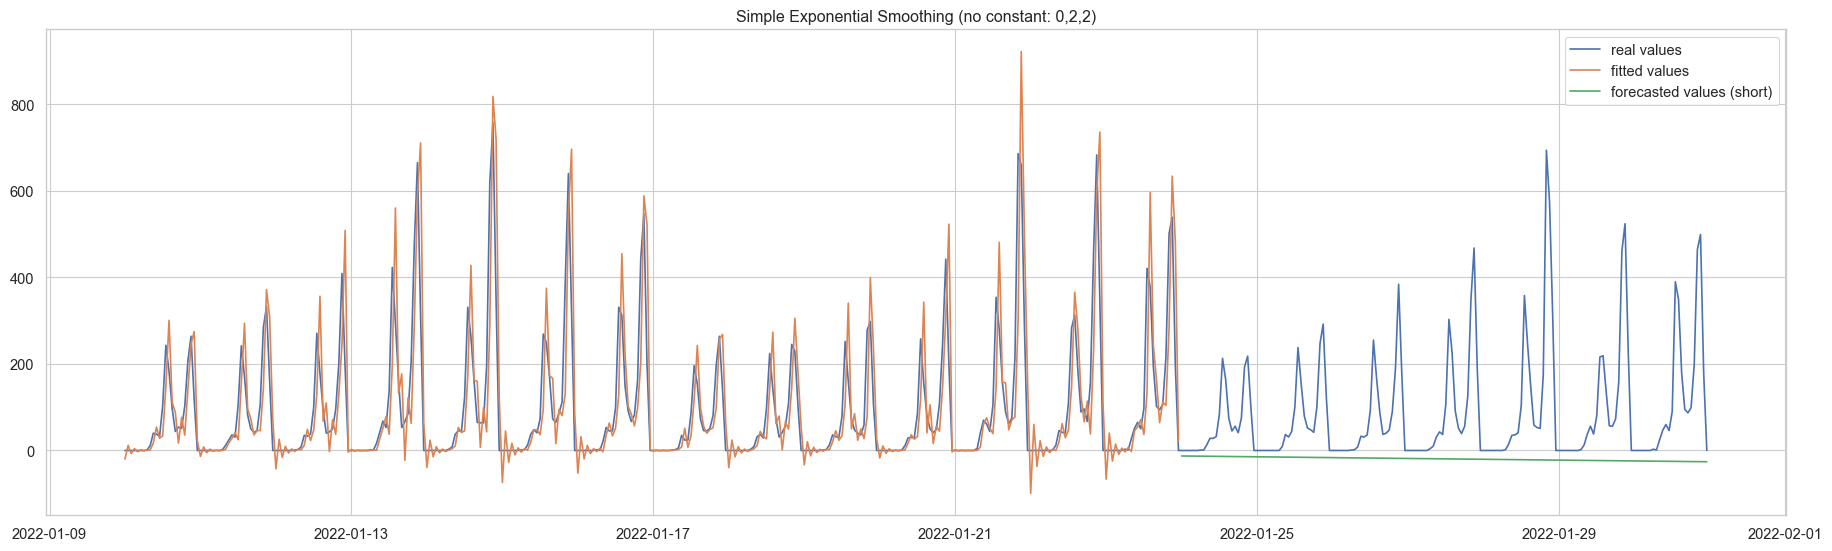

In [300]:
# Linear Exponential Smoothing (no constant)
arima_df_LES = ARIMA(order=(0, 2, 2))

_train = train_arima_rs[TARGET].copy()
arima_df_LES = arima_df_LES.fit(_train)

losses['arima_0_2_2'] = plot_predictions(train_arima_rs, test_arima_rs,
                                         arima_df_LES.predict(test_arima_rs.index), None,
                                         arima_df_LES.predict(train_arima_rs.index), name= 'Simple Exponential Smoothing (no constant: 0,2,2)', 
                                         days_before= diplay_days_before)


print(pd.Series(losses).sort_values())

Fit ARIMA model with additional features:

Here we use extra features such as what day of the week it is.

In [279]:
X_train = train_arima_rs.drop(columns=[TARGET, 'city'])
y_train = np.array(train_arima_rs[TARGET])

X_test = test_arima_rs.drop(columns=[TARGET, 'city'])
y_test = test_arima_rs[TARGET]

In [269]:
#Define the range of p and q values to consider

import itertools
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

p_values = [0,1,2,12]  
d_values = [0,1] 
q_values = [0,1,2] 

# Initialize variables
best_aic = np.inf
best_arima_model = None

# Iterate over combinations of p and q values
for p, d, q in itertools.product(p_values, d_values, q_values):
    # Fit the ARIMA model
    model = ARIMA(y_train, order=(p, d, q), exog=X_train)
    model_fit = model.fit()
    aic = model_fit.aic
    if aic < best_aic:
        best_aic = aic
        best_arma_model = model_fit

# Predict on test data
pred_arma = best_arma_model.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8568
Model:                ARIMA(12, 0, 0)   Log Likelihood              -47327.165
Date:                Sat, 17 Jun 2023   AIC                          94696.331
Time:                        20:49:17   BIC                          94844.502
Sample:                    02-01-2021   HQIC                         94746.874
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -8.23e+04   9359.309     -8.794      0.000   -1.01e+05    -6.4e+04
hour           0.5288      0.323      1.638      0.101      -0.104       1.161
dayofweek      2.5977      1.224      2.122      0.0

rolling_mean      (8003.88, 51.03)
arima_12_0_0    (15631.02, 121.52)
arima_1_0_0     (16991.23, 120.49)
arima_0_1_0       (24665.7, 200.0)
arima_1_1_1      (25548.91, 200.0)
arima_0_2_2       (28711.6, 200.0)
arima_1_1_0      (43782.28, 200.0)
dtype: object


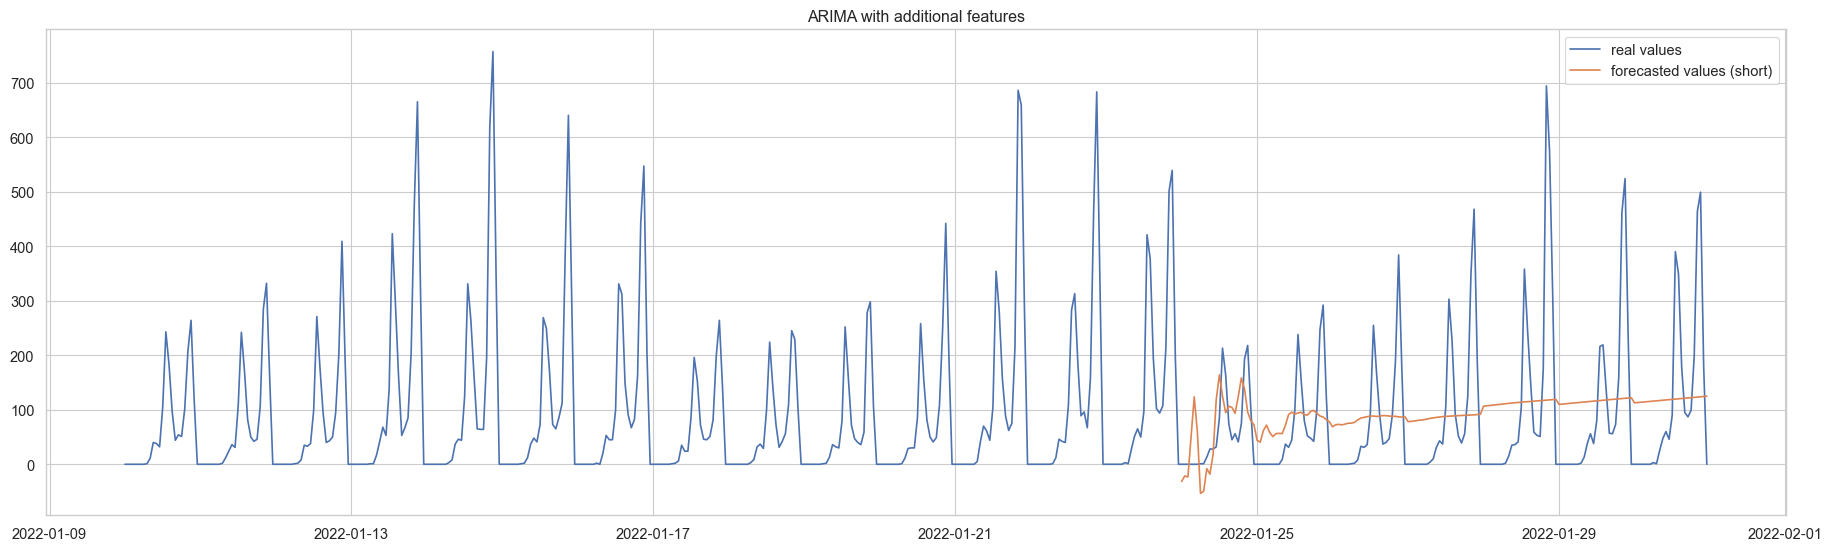

In [280]:
losses['arima_12_0_0'] = plot_predictions(train_arima_rs, test_arima_rs,
                                         pred_arma, None, None, name= 'ARIMA with additional features', days_before= diplay_days_before)


print(pd.Series(losses).sort_values())

## Boosting models